In [1]:
spark.stop()

NameError: name 'spark' is not defined

In [2]:
core = 4
nome = "nicolò"
#nicolò
#marco
#francesco
#raffaele

In [3]:
# Pulizia delle cache (rimuove se ci sono dataframe persistati)

#spark.catalog.clearCache()
import gc
gc.collect()

767

In [4]:
# mapping utenti → (SparkUI, user)
mappa = {
    "nicolò":   (4040, "user_a"),
    "marco":    (4041, "user_b"),
    "francesco":(4042, "user_c"),
    "raffaele": (4043, "user_d"),
}
# recupero SparkUI e user dal mapping
SparkUI, user = mappa[nome]
Npartition = 4*core # Regola generale: numero_partizioni = numero_core * (2 o 4)

print(f"Hai settato {SparkUI} e {user}: tu sei {nome}")

Hai settato 4040 e user_a: tu sei nicolò


sudo pkill -u $(whoami) -f "jupyter-notebook"

# Setting Spark Session

In [62]:
import os
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from functools import reduce
from joblib import Parallel, delayed

from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, TimestampType, BooleanType

from pyspark.sql.functions import (
    coalesce, corr, array, countDistinct, approx_count_distinct,
    col, lit, expr, when, count, count_if, row_number, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg, least,
    first, last, lag, lead, row_number, desc, asc, bool_or, floor,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    window, min_by, mode, concat, monotonically_increasing_id, mean, rand
)

In [6]:
os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"

configs = {
   "spark.scheduler.mode": "FAIR",                                  # Multi-user scheduler
   "spark.scheduler.pool": user,                                    # User pool
   "spark.scheduler.allocation.file": "file:///usr/local/spark/conf/fairscheduler.xml",  # Scheduler config file
   "spark.executor.memory": "1500m",                                # Executor RAM
   "spark.cores.max": core,                                         # Total cores
   "spark.sql.shuffle.partitions": Npartition,                      # Shuffle partitions
   "spark.sql.execution.arrow.pyspark.enabled": "true",             # Enable Arrow
   "spark.sql.execution.arrow.pyspark.fallback.enabled": "false",   # No Arrow fallback
   "spark.dynamicAllocation.enabled": "false",                      # No dynamic allocation
   "spark.shuffle.service.enabled": "false",                        # No shuffle service
   "spark.ui.port": SparkUI,                                        # Custom UI port
   "spark.sql.debug.maxToStringFields": 1000                        # Debug fields limit
}

spark_builder = SparkSession.builder \
   .appName("ProjectCloudVeneto") \
   .master("spark://10.67.22.135:7077")

for key, value in configs.items():
   spark_builder = spark_builder.config(key, value)

spark = spark_builder.getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/20 15:11:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
sensors = ['A5', 'A9', 'ComError', 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
print(sensors)
engines = ["S117", "S118", "S169", "S170"]

['A5', 'A9', 'ComError', 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']


# Upload and inspect dataset

In [8]:
%%time 

df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv").repartition(16, col("hwid"))

# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

[Stage 1:=======================================================> (38 + 1) / 39]

CPU times: user 32.4 ms, sys: 7.29 ms, total: 39.7 ms
Wall time: 44.5 s


In [8]:
# inspect dataset
df.printSchema()

root
 |-- when: integer (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: integer (nullable = true)



In [9]:
# inspect dataset
df.show(3, truncate=False)

[Stage 2:=======================================================> (38 + 1) / 39]

+----------+------+------+-----+
|when      |hwid  |metric|value|
+----------+------+------+-----+
|1602058725|SW-065|S11   |0    |
|1601690338|SW-065|S126  |22   |
|1601743169|SW-065|S124  |0    |
+----------+------+------+-----+
only showing top 3 rows



In [10]:
# inspect hardwares of dataset
hwid_list = df.select("hwid").distinct()
hwid_list.show()

[Stage 7:=====================================================>   (60 + 4) / 64]

+------+
|  hwid|
+------+
|SW-088|
|SW-106|
|SW-115|
|SW-065|
+------+



In [7]:
#Old code to pivot only 1 hardware
'''%%time

hardware = "SW-088" 

df_hw = df.filter(col("hwid") == hardware)\
        .groupBy("when")\
        .pivot("metric")\
        .agg(first("value"))\
        .withColumn("time", from_unixtime(col("when")))\
        .orderBy("when") \
        .repartition(Npartition)

df_hw = df_hw.persist()

# show first 5 rows
engines = ["S117", "S118", "S169", "S170"]
df_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)'''

'%%time\n\nhardware = "SW-088" \n\ndf_hw = df.filter(col("hwid") == hardware)        .groupBy("when")        .pivot("metric")        .agg(first("value"))        .withColumn("time", from_unixtime(col("when")))        .orderBy("when")         .repartition(Npartition)\n\ndf_hw = df_hw.persist()\n\n# show first 5 rows\nengines = ["S117", "S118", "S169", "S170"]\ndf_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)'

In [ ]:
%%time

df_partitioned = df.repartition(16, col("hwid"))

# Process all hardware in parallel with window functions
df_all_hw = (df_partitioned
                   .groupBy("hwid", "when")
                   .pivot("metric")
                   .agg(first("value"))
                   .withColumn("time", from_unixtime(col("when")))
                   .orderBy("hwid", "when"))

df_all_hw = df_all_hw.persist()
df_all_hw.count()

engines = ["S117", "S118", "S169", "S170"]
df_all_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)

[Stage 21:==========================================>             (12 + 4) / 16]

In [10]:
df_all_hw.printSchema()

root
 |-- hwid: string (nullable = true)
 |-- when: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: integer (nullable = true)
 |-- P1: integer (nullable = true)
 |-- P10: integer (nullable = true)
 |-- P15: integer (nullable = true)
 |-- P16: integer (nullable = true)
 |-- P17: integer (nullable = true)
 |-- P18: integer (nullable = true)
 |-- P2: integer (nullable = true)
 |-- P5: integer (nullable = true)
 |-- P6: integer (nullable = true)
 |-- P7: integer (nullable = true)
 |-- P8: integer (nullable = true)
 |-- P9: integer (nullable = true)
 |-- S1: integer (nullable = true)
 |-- S10: integer (nullable = true)
 |-- S100: integer (nullable = true)
 |-- S101: integer (nullable = true)
 |-- S102: integer (nullable = true)
 |-- S106: integer (nullable = true)
 |-- S107: integer (nullable = true)
 |-- S108: integer (nullable = true)
 |-- S109: integer (nullable = true)
 |-- S11: integer (nullable = true)
 |-- S110: integer (

In [ ]:
# Get sensors list
sensors = [field.name for field in df_all_hw.schema.fields 
           if field.name not in ["when", "time", "hwid"] ]

print(sensors)

# Timestamp analysis

In [14]:
def compute_time_differences(df, when_col="when", max_collect=1_000_000):
    rdd_times = df.select(when_col).rdd.map(lambda row: row[when_col])
    rdd_shifted = rdd_times.zipWithIndex().map(lambda x: (x[1], x[0]))  # (index, time)
    rdd_prev = rdd_shifted.map(lambda x: (x[0] + 1, x[1]))              # shift by +1 index
    rdd_joined = rdd_shifted.join(rdd_prev).sortByKey()
    rdd_diff = rdd_joined.map(lambda x: x[1][0] - x[1][1])

    num_diffs = rdd_diff.count()
    print(f"Number of time differences: {num_diffs}")

    if num_diffs < max_collect:
        return rdd_diff
    else:
        print("Too many differences to collect safely.")
        return None

In [15]:
def time_diff_summary(rdd_diff, spark, top_n=5):
    df_freq = rdd_diff.map(lambda d: (d, 1)) \
                      .reduceByKey(lambda a, b: a + b) \
                      .toDF(["diff", "count"]) \
                      .orderBy("diff")

    print(f"\n{top_n} smallest time differences:")
    df_freq.show(top_n, truncate=False)

    print(f"\n{top_n} largest time differences:")
    df_freq.orderBy("diff", ascending=False).show(top_n, truncate=False)

    return df_freq

In [16]:
# Compute time differences
rdd_diff = compute_time_differences(df_hw)

# Summarize and print top/bottom time gaps
df_diff_summary = time_diff_summary(rdd_diff, spark)

Number of time differences: 639868



5 smallest time differences:


+---------+-----+
|diff     |count|
+---------+-----+
|-15401913|1    |
|-15242152|1    |
|-15142182|1    |
|-15114523|1    |
|-15034564|1    |
+---------+-----+
only showing top 5 rows


5 largest time differences:


[Stage 109:===========================================>        (107 + 12) / 128]

+--------+-----+
|diff    |count|
+--------+-----+
|13026641|1    |
|11638832|1    |
|11360621|1    |
|10936729|1    |
|10609354|1    |
+--------+-----+
only showing top 5 rows



In [17]:
def plot_diff_histogram(differences, min_diff, max_diff, delta):
    
    filtered = [d for d in differences if min_diff <= d <= max_diff]

    bins = int((max_diff - min_diff) / delta)

    plt.figure(figsize=(10, 6))
    plt.hist(filtered, bins=bins, color="steelblue", edgecolor="black")
    plt.title(f"Time Difference Events (range {min_diff} - {max_diff} [s])")
    plt.xlabel("Time difference [s]")
    plt.ylabel("Counts")
    plt.show()

In [18]:
diffs = rdd_diff.collect() # check previously the dimension

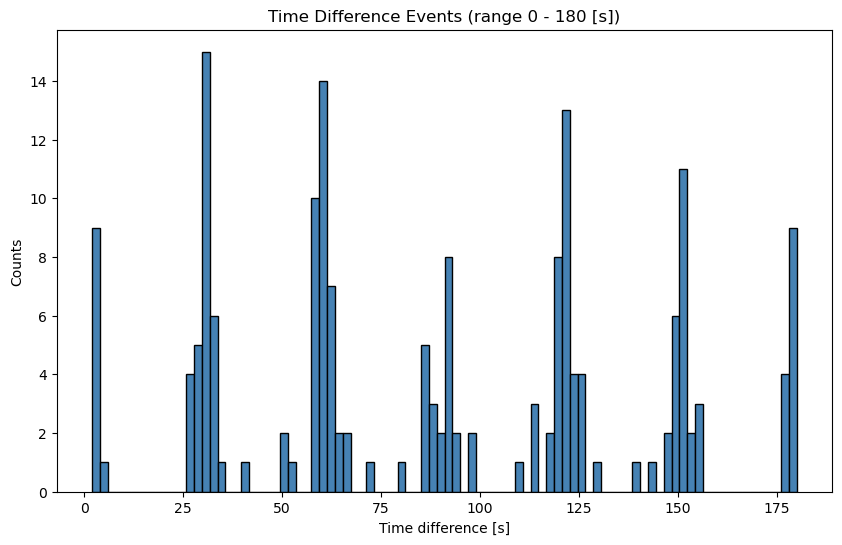

In [19]:
plot_diff_histogram(differences=diffs, min_diff=0, max_diff=180, delta=2)

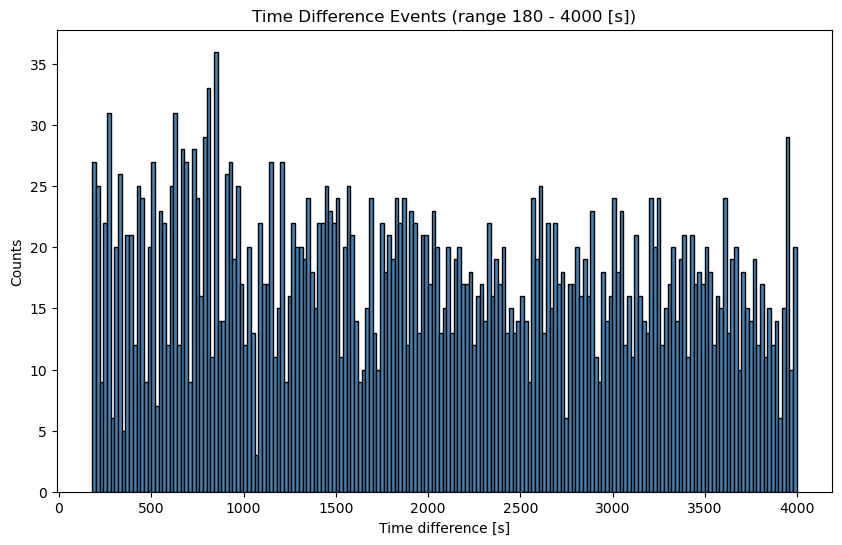

In [20]:
plot_diff_histogram(differences=diffs, min_diff=180, max_diff=4000, delta=20)

# Data preparation

In [ ]:
def CreateGrid(df, interval):

    df_windowed = df.withColumn("time_window", window("time", f"{interval} seconds"))

    aggs = []
    sensors = [c for c in df.columns if c not in ("when", "time", "hwid")]
    for s in sensors:
        stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
        is_binary = stats["min"] is not None and stats["max"] is not None    and    0 <= stats["min"] and stats["max"] <= 1
        if s in ["A5", "A9"] or is_binary:
            agg_func = spark_max(col(s)).alias(s)
        else:
            agg_func = spark_avg(col(s)).alias(s)
        aggs.append(agg_func)

    result_df = (
        df_windowed
        .groupBy("hwid", "time_window")
        .agg(*aggs)
    )

    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )

    return result_df.select(["hwid", "when","window_start","window_end"]+sensors)

In [10]:
%%time

interval = 60 #seconds

#df_grid = CreateGrid(df_all_hw, interval)
#df_grid = df_grid.persist()
#df_grid.select("when","window_start","window_end",*engines).show(3, truncate = False)
#df_all_hw.unpersist()

[Stage 981:===================================================>   (60 + 4) / 64]

+----------+-------------------+-------------------+----+----+----+----+
|when      |window_start       |window_end         |S117|S118|S169|S170|
+----------+-------------------+-------------------+----+----+----+----+
|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|0   |0   |NULL|NULL|
|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|0   |1   |0   |1   |
|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|0   |0   |1   |0   |
+----------+-------------------+-------------------+----+----+----+----+
only showing top 3 rows

CPU times: user 246 ms, sys: 112 ms, total: 358 ms
Wall time: 35.2 s


DataFrame[hwid: string, when: int, A5: int, A9: int, ComError: int, P1: int, P10: int, P15: int, P16: int, P17: int, P18: int, P2: int, P5: int, P6: int, P7: int, P8: int, P9: int, S1: int, S10: int, S100: int, S101: int, S102: int, S106: int, S107: int, S108: int, S109: int, S11: int, S110: int, S112: int, S113: int, S114: int, S115: int, S117: int, S118: int, S122: int, S123: int, S124: int, S125: int, S126: int, S127: int, S128: int, S129: int, S130: int, S137: int, S138: int, S140: int, S143: int, S147: int, S15: int, S151: int, S154: int, S157: int, S158: int, S159: int, S16: int, S163: int, S164: int, S165: int, S166: int, S167: int, S169: int, S17: int, S170: int, S171: int, S172: int, S173: int, S174: int, S175: int, S176: int, S178: int, S179: int, S180: int, S181: int, S183: int, S19: int, S2: int, S201: int, S202: int, S203: int, S204: int, S205: int, S206: int, S25: int, S3: int, S33: int, S34: int, S35: int, S37: int, S39: int, S40: int, S41: int, S42: int, S43: int, S45: 

# START FROM HERE TO IMPORT df_grid

In [9]:
df_grid = spark.read.parquet("/mnt/shared/df_grid.parquet/")

In [10]:
df_grid = df_grid.withColumn("A5", col("A5").cast("int"))
df_grid = df_grid.withColumn("A9", col("A9").cast("int"))

In [11]:
def BuildBlocks(df, max_interval, sensors):    

    w_hw = Window.partitionBy("hwid").orderBy("when")
    df = (df
          .withColumn("Prev_TimeStamp", lag("when").over(w_hw))
          .withColumn("Next_TimeStamp", lead("when").over(w_hw))
          .withColumn("PrevDiff_s", col("when") - col("Prev_TimeStamp"))
          .withColumn("NextDiff_s", col("Next_TimeStamp") - col("when"))
         )

    #Check if the timediff between two consecutive data is more than max_interval
    df = df.withColumn("CheckNewBlock", when(col("PrevDiff_s") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", spark_sum("CheckNewBlock").over(w_hw))

    df.drop("CheckNewBlock")

    return df

In [12]:
df_blocks = BuildBlocks(df_grid, max_interval = 1800, sensors = sensors)

In [13]:
df_blocks.select("hwid", "when", "window_start", "window_end", "BlockID", "S117", "PrevDiff_s", "A9", "A5").show(3)

[Stage 5:>                                                          (0 + 1) / 1]

+------+----------+-------------------+-------------------+-------+----+----------+----+----+
|  hwid|      when|       window_start|         window_end|BlockID|S117|PrevDiff_s|  A9|  A5|
+------+----------+-------------------+-------------------+-------+----+----------+----+----+
|SW-088|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|      0| 0.0|      NULL|NULL|NULL|
|SW-088|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|      0| 0.0|        60|NULL|NULL|
|SW-088|1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00|      0| 0.0|        60|NULL|NULL|
+------+----------+-------------------+-------------------+-------+----+----------+----+----+
only showing top 3 rows



In [14]:
df_blocks.count()

671830

## mini-parte null

In [ ]:
def fill_null(df, sensors, max_gap=240):
    w_prev = Window.partitionBy("hwid","BlockID").orderBy("when").rowsBetween(Window.unboundedPreceding, -1)
    w_next = Window.partitionBy("hwid","BlockID").orderBy("when").rowsBetween(1, Window.unboundedFollowing)

    for s in sensors:
        if s not in ["A5","A9","ComError"]:
            prev_val = last(col(s), ignorenulls=True).over(w_prev)
            next_val = first(col(s), ignorenulls=True).over(w_next)
    
            df = df.withColumn(
                s,
                when( col(s).isNotNull(), col(s))
                .when(
                     (col("NextDiff_s") <= max_gap) &
                     (col("NextDiff_s") <= col("PrevDiff_s")),
                     next_val
                )
                .when(col("PrevDiff_s") <= max_gap, prev_val)
            )
    return df

In [ ]:
%%time
df_prova = fill_null ( df_blocks, sensors, max_gap=240)

In [ ]:
# questo ci mette una vita --- però si vede che i sensori hanno pochissimi null
#(poi penso siano tanti nella stessa riga, perché se printi i null originari vedi che tanti sensori hanno null allostesso when, penso siano quelli dell'oveheating con A5 e A9 diversi da null)
for s in sensors:
    n_null = df_prova.select(count(when(col(s).isNull(), s))).collect()[0][0]
    print(f"sensore {s} ha {n_null} valori che sono null.")

# print("Qui su tutti e 4 gli hw assieme. Df del numero di null")
# agg_exprs = [count(when(col(s).isNull(), s)).alias(s) for s in sensors]
# df_nulls = df_grid.agg(*agg_exprs)
# df_nulls.show()



In [21]:
for s in["A5","A9","ComError"]:
    n_null = df_grid.select(count(when(col(s).isNull(), s))).collect()[0][0]
    print(f"sensore {s} ha {n_null} valori che sono null.")

sensore A5 ha 671185 valori che sono null.
sensore A9 ha 671190 valori che sono null.
sensore ComError ha 671803 valori che sono null.


In [22]:
for s in sensors:
    n_null = df_grid.select(count(when(col(s).isNull(), s))).collect()[0][0]
    print(f"sensore {s} ha {n_null} valori che sono null.")

sensore A5 ha 671185 valori che sono null.
sensore A9 ha 671190 valori che sono null.
sensore ComError ha 671803 valori che sono null.
sensore P1 ha 3513 valori che sono null.
sensore P10 ha 3514 valori che sono null.
sensore P15 ha 3515 valori che sono null.
sensore P16 ha 3512 valori che sono null.
sensore P17 ha 3515 valori che sono null.
sensore P18 ha 3515 valori che sono null.
sensore P2 ha 3513 valori che sono null.
sensore P5 ha 3515 valori che sono null.
sensore P6 ha 3516 valori che sono null.
sensore P7 ha 3512 valori che sono null.
sensore P8 ha 3516 valori che sono null.
sensore P9 ha 3516 valori che sono null.
sensore S1 ha 3518 valori che sono null.
sensore S10 ha 3514 valori che sono null.
sensore S100 ha 3512 valori che sono null.
sensore S101 ha 3515 valori che sono null.
sensore S102 ha 3513 valori che sono null.
sensore S106 ha 3512 valori che sono null.
sensore S107 ha 3515 valori che sono null.
sensore S108 ha 3514 valori che sono null.
sensore S109 ha 3515 valori

In [23]:
# # droppiamo tutti i NULL (sembrava bello ma non potremo farlo veramente)

# sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
# df_blocks_NoNa = df_blocks.na.drop(subset=sensors)
# df_blocks_NoNa.count()

651501

In [24]:
list_hw = df_blocks.select("hwid").distinct().rdd.flatMap(lambda x : x).collect()
list_hw

['SW-088', 'SW-106', 'SW-115', 'SW-065']

In [25]:
for hw in list_hw:
    print(f"{hw} has {df_blocks_NoNa.where(col("hwid") == hw).select('BlockID').distinct().count()} Blocks.")

SW-088 has 1040 Blocks.


SW-106 has 185 Blocks.


SW-115 has 78 Blocks.


[Stage 485:>                                                        (0 + 1) / 1]

SW-065 has 101 Blocks.


In [27]:
recreate = False

if recreate:
    #Transoform each hwid into panda dataframe and then combine (no memory issue)
    all_chunks = []
    for hwid in df_blocks.select("hwid").distinct().collect():
        hwid_value = hwid['hwid']
        chunk = df_blocks.filter(f"hwid = '{hwid_value}'").toPandas()
        all_chunks.append(chunk)
        
    # Combine
    pandas_df = pd.concat(all_chunks, ignore_index=True)
    pandas_df.to_parquet("/mnt/shared/df_final.parquet", index=False)

--------------------------SW-088------------------------------
Longest blocks:

      BlockID  minutes
1044      460     2095
1045      483     2135
1046      164     2374


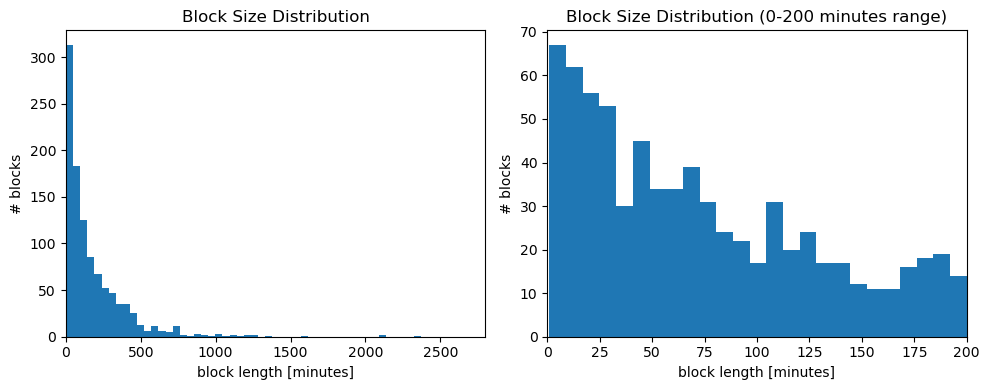

--------------------------SW-106------------------------------
Longest blocks:

     BlockID  minutes
183      180     3510
184      175     3963
185      182     4658


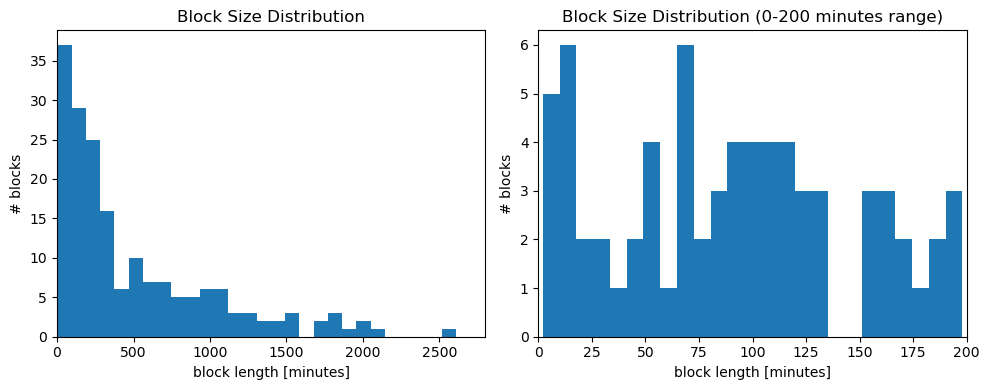

--------------------------SW-115------------------------------
Longest blocks:

    BlockID  minutes
75       73     8623
76       23    10977
77        8    14200


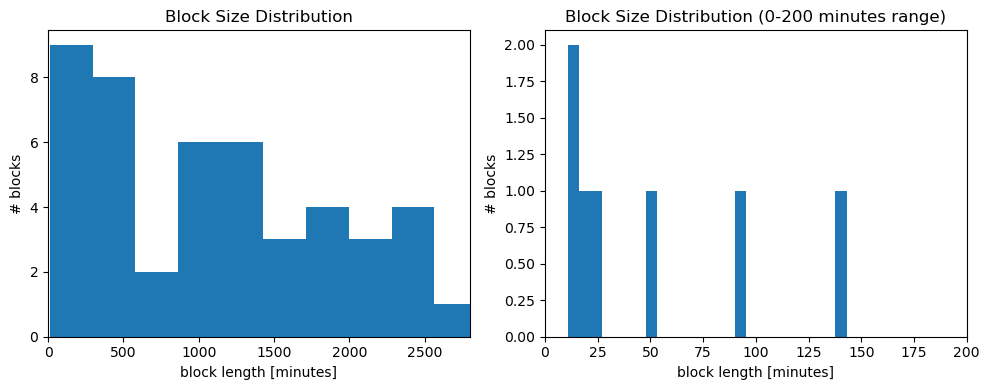

--------------------------SW-065------------------------------
Longest blocks:

     BlockID  minutes
98        40     5123
99        12     6205
100       15    12744


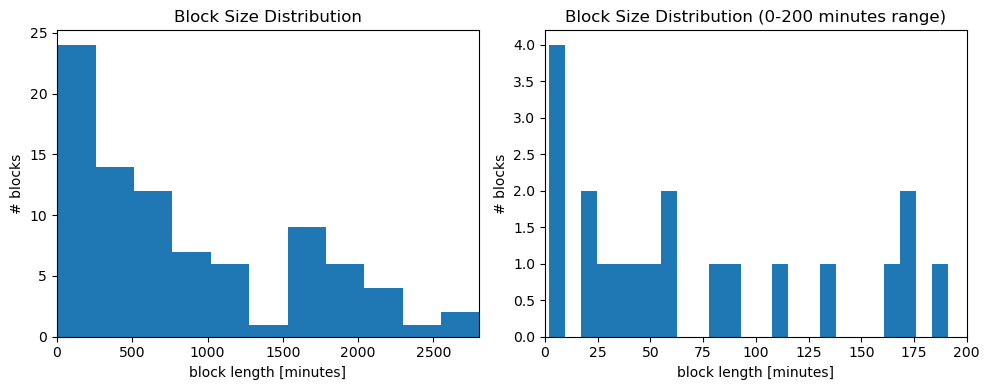

In [26]:
for hw in list_hw:


    print(f"--------------------------{hw}------------------------------")
    dist_blocks = df_blocks.where(col("hwid")==hw).groupBy("BlockID").agg(count("*").alias("minutes")).orderBy("minutes")
    data = dist_blocks.toPandas()
    print("Longest blocks:\n")
    print( data.tail(3) )
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(data['minutes'], bins=50)
    axes[0].set_xlim(0, 2800)
    axes[0].set_xlabel("block length [minutes]")
    axes[0].set_ylabel("# blocks")
    axes[0].set_title("Block Size Distribution")
    
    data_low_range = data[(data['minutes'] >= 0) & (data['minutes'] <= 200)]
    axes[1].hist(data_low_range['minutes'], bins=25)
    axes[1].set_xlim(0, 200)
    axes[1].set_xlabel("block length [minutes]")
    axes[1].set_ylabel("# blocks")
    axes[1].set_title("Block Size Distribution (0-200 minutes range)")
    plt.tight_layout()
    plt.show()

# Anomaly detection

In [27]:
def detect_anomalies(df, time_separator, threshold, sensors):
    '''
    Crea colonne con flag per anomalie.
    '''
    # Lag to get previous value within each partition (i.e. within each block)
    window         = Window.partitionBy("BlockID").orderBy("when")
    lagged_columns = [lag(col(s)).over(window) for s in sensors] 
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Determina switch del sensore (didSwitch = 1 se il sensore passa da 0 a 1 o viceversa, didSwitch = 0 altrimenti)
    switch_w     = Window.partitionBy('BlockID').orderBy('when')
    didSwitch    = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] 
    switch_names = [f"didSwitch_{s}" for s in sensors]    

    df_didSwitch = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Detect anomaly group: when two clusters are more distant than time_separator they are grouped as different anomalies
    # Tutte le anomalie di uno stesso gruppo hanno stesso id, cioè un numero crescente che si resetta ad ogni nuovo blocco
    df_anomalies = df_didSwitch
    for sensor in sensors:   
        # Il periodo anomalo inizia quando il sensore è 1 e finisce quando esso è 0
        df_start = (
            df_didSwitch \
            .withColumn(f'theres0Before_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(1, time_separator)) > 0) \
            .withColumn(f'theres0After_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(-time_separator, -1)) > 0) \
            .filter( 
                (col(f'didSwitch_{sensor}') == 1) & 
                (when(col(sensor) == 1, col(f'theres0Before_{sensor}')).otherwise(True)) &
                (when(col(sensor) == 0, col(f'theres0After_{sensor}')).otherwise(True))
            ) \
            .withColumn(f'startGroup_{sensor}', when((col('when')-lag(col('when'), 1, -1e9).over(window))>time_separator, 1).otherwise(0)) \
            .withColumn(f'anomalyID_{sensor}', spark_sum(col(f'startGroup_{sensor}')).over(window)) \
        )
        
        df_anomalies = df_anomalies.join(
            other = df_start.select('BlockID', 'when', f'startGroup_{sensor}', f'anomalyID_{sensor}'),
            on = ['BlockID', 'when'],
            how = 'left'
        )

    count_names = [f'count_{s}' for s in sensors]
    count_cols  = [count('*').over(Window.partitionBy('BlockID', f'anomalyID_{s}')) for s in sensors]

    flag_names  = [f'flag_{s}' for s in sensors]
    flag_cols   = [when((col(f'count_{s}') >= threshold) & (col(f'anomalyID_{s}') > 0), True).otherwise(False) for s in sensors]
    
    df_flag = df_anomalies \
        .withColumns(dict(zip(count_names, count_cols))) \
        .withColumns(dict(zip(flag_names, flag_cols))) \
        .orderBy('BlockID', 'when')

    # Quando ci sono delle righe comprese tra anomalie con stesso ID, queste righe sono a loro volta considerate anomalie
    next_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(0, time_separator)
    prev_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(-time_separator, 0)

    prev_names = [f'prevID_{s}' for s in sensors]
    prev_id = [when((bool_or(f'flag_{s}').over(prev_w)), spark_max(f'anomalyID_{s}').over(prev_w)).otherwise(None) for s in sensors]
    next_names = [f'nextID_{s}' for s in sensors]
    next_id = [when((bool_or(f'flag_{s}').over(next_w)), spark_min(f'anomalyID_{s}').over(next_w)).otherwise(None) for s in sensors]

    df_newID = (
        df_flag \
            .withColumns(dict(zip(prev_names, prev_id))) \
            .withColumns(dict(zip(next_names, next_id)))
    )

    new_flags = [when((col(f'nextID_{s}') == col(f'prevID_{s}')) & (col(f'nextID_{s}') > 0), True).otherwise(col(f'flag_{s}')) for s in sensors]
    
    df_flag = df_newID.withColumns(dict(zip(flag_names, new_flags)))
    
    condition = reduce(lambda a, b: a | b, [col(f'flag_{s}') for s in sensors])
    df_flag = df_flag.withColumn('flag_anomaly', when(condition, 1).otherwise(0))

    return df_flag \
        .select("BlockID", "when", *sensors, *flag_names, 'flag_anomaly') 

In [28]:
%%time

list_df_anomalies = {}
for hw in list_hw:
    df_anomalies = detect_anomalies(
        df = df_blocks.filter( col("hwid") == hw),
        time_separator = 60*30, # seconds
        threshold = 8,
        sensors = engines
    )

    list_df_anomalies[hw] = df_anomalies

list_df_anomalies

CPU times: user 168 ms, sys: 71.8 ms, total: 240 ms
Wall time: 7.76 s


{'SW-088': DataFrame[BlockID: bigint, when: bigint, S117: double, S118: double, S169: double, S170: double, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-106': DataFrame[BlockID: bigint, when: bigint, S117: double, S118: double, S169: double, S170: double, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-115': DataFrame[BlockID: bigint, when: bigint, S117: double, S118: double, S169: double, S170: double, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-065': DataFrame[BlockID: bigint, when: bigint, S117: double, S118: double, S169: double, S170: double, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int]}

In [29]:
hw_to_inspect = 'SW-088'

In [30]:
%%time

list_df_anomalies[hw_to_inspect].filter('flag_S117').show(3, truncate=False)

+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|BlockID|when      |S117|S118|S169|S170|flag_S117|flag_S118|flag_S169|flag_S170|flag_anomaly|
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|202    |1605099030|1.0 |0.0 |0.0 |0.0 |true     |true     |false    |false    |1           |
|202    |1605099090|1.0 |0.0 |0.0 |0.0 |true     |true     |false    |false    |1           |
|202    |1605099150|1.0 |0.0 |0.0 |0.0 |true     |true     |false    |false    |1           |
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
only showing top 3 rows

CPU times: user 7.36 ms, sys: 662 μs, total: 8.02 ms
Wall time: 4.21 s


In [31]:
print("Know some BlockID where there are anomalies, so we can plot it and see.")

BlockWithAnom = list_df_anomalies[hw_to_inspect].filter('flag_S117').select('BlockID').distinct().orderBy('BlockID')
BlockWithAnom.show(3, truncate=False)

Know some BlockID where there are anomalies, so we can plot it and see.
+-------+
|BlockID|
+-------+
|202    |
|212    |
|234    |
+-------+
only showing top 3 rows



In [32]:
def inspect_anomalies(df, sensor, blockID):

    def extract_column(df, column, default):
        return df.filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df, sensor, 0)
    anomalies = extract_column(df, f'flag_{sensor}', False)
    t = range(len(anomalies))

    plt.bar(t, values, width = 1, alpha = 0.5, edgecolor=None, lw=1)
    plt.bar(t, anomalies, width= 1, alpha = 0.5, label="anomal")
    plt.xlabel("Minutes")
    plt.ylabel(sensor)
    plt.legend(loc='lower right')
    plt.title(f"Block N.{blockID}")
    plt.legend()
    plt.show()

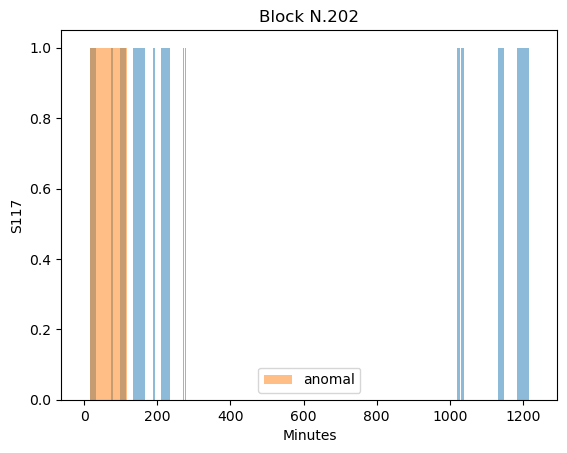

In [33]:
inspect_anomalies(list_df_anomalies[hw_to_inspect], 'S117', BlockWithAnom.first()[0])

In [34]:
# Join on `when` and take just `flag_anomaly`

list_df_blocks_anom = {}

for hw in list_hw:
    df_anom = list_df_anomalies[hw].select('when', 'flag_anomaly')
    # df_anom = spark.createDataFrame(df_anom.rdd, df_anom.schema)  # Break lineage
    list_df_blocks_anom[hw] = df_blocks.filter( col("hwid") == hw ).join( df_anom, on='when', how='left' )
    #df_blocks_anom = df_blocks_anom.persist()

list_df_blocks_anom[hw_to_inspect].show(1)

[Stage 836:>                                                        (0 + 1) / 1]

+----------+------+-------------------+-------------------+----+----+--------+---+-----+---+-----+-----+-----+---+-----+-----+-----+-----+-----+---+---+-----+-----+-----+----+-----+----+-----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+----+----+----+----+----+---+----+----+----+----+----+---+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+---+---+----+----+----+----+----+----+---+-----+---+---+---+---+-----+-----+-----+---+---+---+-----+-----+---+---+---+---+---+---+---+---+-----+---+---+---+---+---+-----+-----+---+---+-----+-----+-----+---+---+---+---+-----+---+----+----+----+---+---+---+-------+---+---+---+---+---+--------------+--------------+----------+----------+-------------+-------+------------+
|      when|  hwid|       window_start|         window_end|  A5|  A9|ComError| P1|  P10|P15|  P16|  P17|  P18| P2|   P5|   P6|   P7|   P8|   P9| S1|S10| S100| S101| S102|S106| S107|S108| S109|S11|S11

# A5 A9 Alarms

In [35]:
def extract_alarms(df, columns=["A5", "A9"], bits=[6, 7, 8]):
    for col_name in columns:
        for bit in bits:
            convert_bit = bit - 1  # bit 1 is LSB
            df = df.withColumn( f"{bit}-{col_name}", ((col(col_name).bitwiseAND(1 << convert_bit)) > 0).cast("int") )
    
    all_bit_cols = [col(f"{bit}-{col_name}") for col_name in columns for bit in bits]
    
    # condition ad least one alarm to get overheating
    condition = sum(all_bit_cols) > 0 # already menaged NULL, it gives 0
    df = df.withColumn("overheating", when(condition, 1).otherwise(0).cast("int"))
 
    return df

In [36]:
# Extract bits from alarms

list_df_alarms = {}
for hw in list_hw:
    df_alarms = extract_alarms( df_grid.filter( col("hwid") == hw).select("when","A5","A9"),
                            columns=["A5", "A9"],
                            bits=[6, 7, 8] )

    list_df_alarms[hw] = df_alarms
    print( f"For hardware {hw} were recorded {df_alarms.agg(spark_sum("overheating")).collect()[0][0]} overheating signals." )

#list_df_alarms['SW-088'].show(3)
#list_df_alarms['SW-088'].where( (col("A5").isNotNull()) | (col("A9").isNotNull()) ).show(3)
list_df_alarms['SW-088'].where( col("overheating") == 1 ).show(3)

For hardware SW-088 were recorded 66 overheating signals.
For hardware SW-106 were recorded 0 overheating signals.
For hardware SW-115 were recorded 0 overheating signals.
For hardware SW-065 were recorded 0 overheating signals.
+----------+-----+---+----+----+----+----+----+----+-----------+
|      when|   A5| A9|6-A5|7-A5|8-A5|6-A9|7-A9|8-A9|overheating|
+----------+-----+---+----+----+----+----+----+----+-----------+
|1601510790|18496|  0|   0|   1|   0|   0|   0|   0|          1|
|1601597190|18496|  0|   0|   1|   0|   0|   0|   0|          1|
|1601686290|18496|  0|   0|   1|   0|   0|   0|   0|          1|
+----------+-----+---+----+----+----+----+----+----+-----------+
only showing top 3 rows



In [37]:
%%time

list_df_final = {}

print("Check previous n° of alarms with respect to total lines.\n")

for hw in list_hw:
    df_final = list_df_blocks_anom[hw].join( list_df_alarms[hw].select('when', 'overheating') , on='when', how='left' )
    #list_df_final[hw] = df_final.persist()
    list_df_final[hw] = df_final
    print( f"For hardware {hw} there are {list_df_final[hw].count()} lines" )

Check previous n° of alarms with respect to total lines.

For hardware SW-088 there are 191987 lines
For hardware SW-106 there are 105885 lines
For hardware SW-115 there are 237674 lines
For hardware SW-065 there are 136284 lines
CPU times: user 12.2 ms, sys: 2.86 ms, total: 15 ms
Wall time: 8.39 s


# Correlations setup ( anomaly, S125-S181, A5-A9)

In [40]:
%%time

# consider only changing sensors for correlations tasks

real_sensors = [s for s in sensors if s not in ["A5", "A9", *engines]]

counts = df_final.agg(*(countDistinct(c).alias(c) for c in real_sensors)).first().asDict()

useful_sensors = [c for c, v in counts.items() if v > 1]

[Stage 1004:==========================================>             (3 + 1) / 4]

CPU times: user 59.8 ms, sys: 12.1 ms, total: 71.9 ms
Wall time: 37.2 s


In [41]:
print(f"There are {len(useful_sensors)} sensors with more than one distinct values")
print(useful_sensors)

There are 30 sensors with more than one distinct values
['S10', 'S100', 'S102', 'S109', 'S112', 'S122', 'S125', 'S126', 'S128', 'S130', 'S138', 'S151', 'S157', 'S159', 'S166', 'S171', 'S178', 'S181', 'S201', 'S204', 'S3', 'S39', 'S40', 'S41', 'S5', 'S53', 'S71', 'S73', 'S81', 'S94']


In [42]:
def correlations(df, sensors_list, target_col, batch_size=25):
    """
    Compute correlations between sensors and target column in batches.
    Returns sorted DataFrame by absolute correlation (descending).
    """   
    all_correlations = []
    
    # Process sensors in batches to avoid broadcasting large tasks
    for i in range(0, len(sensors_list), batch_size):
        batch_sensors = sensors_list[i:i + batch_size]
        
        # Create correlation expressions for current batch
        corr_expressions = [corr(target_col, sensor).alias(f"corr_{sensor}") for sensor in batch_sensors]
        
        # Execute correlations for this batch
        batch_results = df.agg(*corr_expressions).collect()[0]
        
        # Extract correlation values (handle nulls as 0.0)
        batch_correlations = [batch_results[f"corr_{sensor}"] or 0.0 
                            for sensor in batch_sensors]
        all_correlations.extend(batch_correlations)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        "Sensors": sensors_list, 
        "Correlations": all_correlations
    })
    
    # Sort by absolute correlation (highest first)
    sorted_results = results_df.reindex(
        results_df["Correlations"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    
    return sorted_results

In [43]:
def plot_correlations(df_spark, target_col, feature_cols, corr_df):
    import matplotlib.pyplot as plt
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        corr_val = corr_df[corr_df["Sensors"] == feature]["Correlations"].values
        corr_str = f"{corr_val[0]:.3f}" if len(corr_val) > 0 else "N/A"
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.scatter(pd_df[feature], pd_df[target_col], color="steelblue", alpha=0.005)
        ax1.set_ylabel(target_col)
        
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            ax2.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                    label=f"{target_col}={target_val}", density=True)
        
        ax2.set_ylabel("Density")
        ax2.legend()
        
        fig.suptitle(f"{feature} - Correlation: {corr_str}")
        plt.tight_layout()
        plt.show()

### PCA

In [44]:
df_final.printSchema()
df_anomalies_n = df_final
pca_sensors = [ 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10','S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW', 'flag_anomaly']
df_anomalies_n = df_anomalies_n.select(pca_sensors)
df_anomalies_n = df_anomalies_n.na.drop()
df_anomalies_n.printSchema()
df_anomalies_n.show(5)

root
 |-- when: long (nullable = true)
 |-- hwid: string (nullable = true)
 |-- window_start: timestamp_ntz (nullable = true)
 |-- window_end: timestamp_ntz (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: double (nullable = true)
 |-- P1: double (nullable = true)
 |-- P10: double (nullable = true)
 |-- P15: double (nullable = true)
 |-- P16: double (nullable = true)
 |-- P17: double (nullable = true)
 |-- P18: double (nullable = true)
 |-- P2: double (nullable = true)
 |-- P5: double (nullable = true)
 |-- P6: double (nullable = true)
 |-- P7: double (nullable = true)
 |-- P8: double (nullable = true)
 |-- P9: double (nullable = true)
 |-- S1: double (nullable = true)
 |-- S10: double (nullable = true)
 |-- S100: double (nullable = true)
 |-- S101: double (nullable = true)
 |-- S102: double (nullable = true)
 |-- S106: double (nullable = true)
 |-- S107: double (nullable = true)
 |-- S108: double (nullable = true)
 |-- S109: double

+---+-----+---+-----+-----+-----+---+-----+-----+-----+-----+-----+---+----+-----+---+----+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+-----+----+-----+---+----+----+----+-----+----+----+---+----+----+----+----+----+----+----+-----+----+----+----+---+---+------+------+----+------+------+----+---+-----+---+---+---+---+-----+-----+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+----+---+---+---+---+----+---+---+----+----+----+---+---+---+---+---+---+---+---+---+------------+
| P1|  P10|P15|  P16|  P17|  P18| P2|   P5|   P6|   P7|   P8|   P9| S1| S10| S109|S11|S110|S112|S113|S114|S115|S117|S118| S122|S123|S124|S125|S126|S127|S128|S129|S130|S137|S138|S140|S143|S147|S15|S151|S154| S157|S158| S159|S16|S163|S164|S165| S166|S167|S169|S17|S170|S171|S172|S173|S174|S175|S176| S178|S179|S181|S183|S19| S2|  S201|  S202|S203|  S204|  S205|S206|S25|   S3|S33|S34|S35|S37|  S39|

In [59]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

def covariance_matrix(df, cols=None):
    """
    This function returns the covariance matrix from the df
    """
    
    if cols is None:
        cols = df.columns

    for c in cols:
        df = df.withColumn(c, col(c).cast(DoubleType()))
    
    means = df.select([mean(c).alias(c) for c in cols]).collect()[0].asDict()
    
    df_centered = df.select(*[(col(c) - means[c]).alias(c) for c in cols])
    
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    df_centered_vec = assembler.transform(df_centered).select("features")
    
    n = df.count()
    cov_matrix = (
        df_centered_vec.rdd
        .map(lambda row: row.features.toArray())
        .map(lambda x: np.outer(x, x))
        .reduce(lambda a, b: a + b) / (n - 1)
    )
    
    return cov_matrix, cols

cov_matrix, columns = covariance_matrix(df_anomalies_n)

print("Columns:", columns)
print("Covariance matrix:\n", cov_matrix)

25/08/18 20:23:15 WARN DAGScheduler: Broadcasting large task binary with size 1180.3 KiB
25/08/18 20:23:17 WARN DAGScheduler: Broadcasting large task binary with size 1305.3 KiB
25/08/18 20:23:17 WARN DAGScheduler: Broadcasting large task binary with size 1095.6 KiB
25/08/18 20:23:18 WARN DAGScheduler: Broadcasting large task binary with size 1139.2 KiB
[Stage 2446:==================================================>   (30 + 2) / 32]

Columns: ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW', 'flag_anomaly']
Covariance matrix:
 [[1.09463323e-01 6.13360572e-01 0.00000000e+00 ... 3.781

In [60]:
def pca_from_cov(cov_matrix, cols, verbose = False):
    """
    PCA from covariance matrix
    """
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    explained_var_ratio = eigvals / eigvals.sum()

    if verbose:
        print("Covariance matrix:\n", cov_matrix, "\n")
        print("Eigenvalues (variance explained):", eigvals)
        print("Explained variance ratio:", explained_var_ratio, "\n")
        print("Principal Components (eigenvectors):")
        for i in range(len(cols)):
            print(f"PC{i+1} ({explained_var_ratio[i]*100:.2f}% variance):")
            for col, weight in zip(cols, eigvecs[:, i]):
                print(f"  {col}: {weight:.4f}")
            print()


pca_from_cov(cov_matrix, columns, verbose = True)

Covariance matrix:
 [[1.09463323e-01 6.13360572e-01 0.00000000e+00 ... 3.78153840e+01
  0.00000000e+00 3.26019386e-03]
 [6.13360572e-01 3.01195026e+02 0.00000000e+00 ... 1.17662451e+04
  0.00000000e+00 6.79750618e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.78153840e+01 1.17662451e+04 0.00000000e+00 ... 5.78440068e+06
  0.00000000e+00 6.23813232e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.26019386e-03 6.79750618e-01 0.00000000e+00 ... 6.23813232e+01
  0.00000000e+00 6.51209047e-02]] 

Eigenvalues (variance explained): [ 1.20810181e+07  5.84359268e+06  2.38466575e+05  8.18575395e+04
  6.65459948e+04  2.43943704e+04  2.04491461e+04  1.86374158e+04
  1.07924314e+04  8.84420643e+03  7.81880992e+03  5.60204162e+03
  5.08340295e+03  3.65251130e+03  2.42565753e+03  1.71607597e+03
  1.21707763e+03  1.17145810e+03  9.66584280e+02  8.60856913e+02
  6.94484841e+02  6

# Correlations (S117,S118,S169,S170)

In [61]:
%%time

anomaly_corr = correlations(df_final.select(*useful_sensors,"flag_anomaly"), useful_sensors, "flag_anomaly")
top_anomaly_corr = anomaly_corr.head(5)["Sensors"].tolist()

25/08/18 20:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1170.8 KiB
25/08/18 20:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1269.6 KiB
25/08/18 20:23:37 WARN DAGScheduler: Broadcasting large task binary with size 1170.4 KiB
25/08/18 20:23:39 WARN DAGScheduler: Broadcasting large task binary with size 1269.0 KiB
25/08/18 20:23:39 WARN DAGScheduler: Broadcasting large task binary with size 1170.8 KiB
25/08/18 20:23:41 WARN DAGScheduler: Broadcasting large task binary with size 1269.6 KiB
25/08/18 20:23:41 WARN DAGScheduler: Broadcasting large task binary with size 1160.6 KiB
25/08/18 20:23:44 WARN DAGScheduler: Broadcasting large task binary with size 1247.6 KiB


CPU times: user 30.7 ms, sys: 71.2 ms, total: 102 ms
Wall time: 10.1 s


In [62]:
anomaly_corr.head(5)

,Sensors,Correlations
0,S109,0.347418
1,S126,0.310335
2,S122,0.290440
3,S125,0.284869
4,S102,0.279668


25/08/18 20:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1088.0 KiB


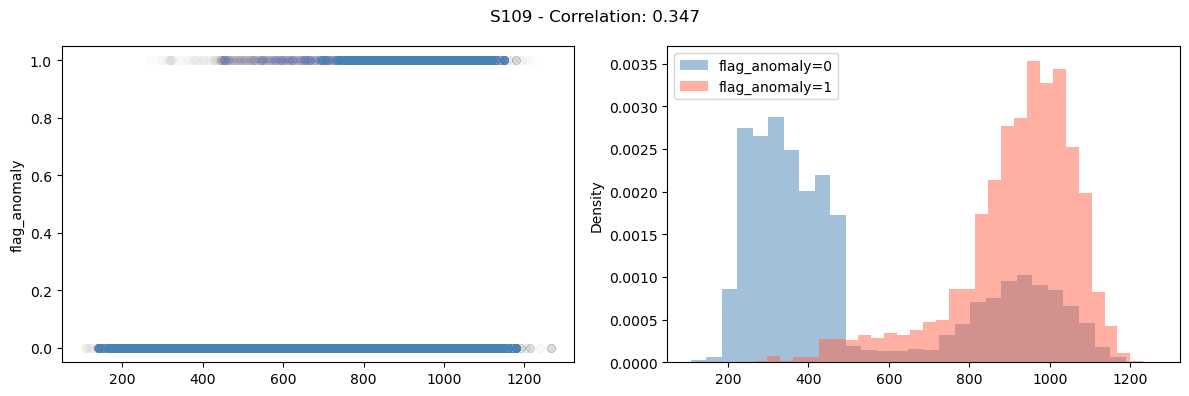

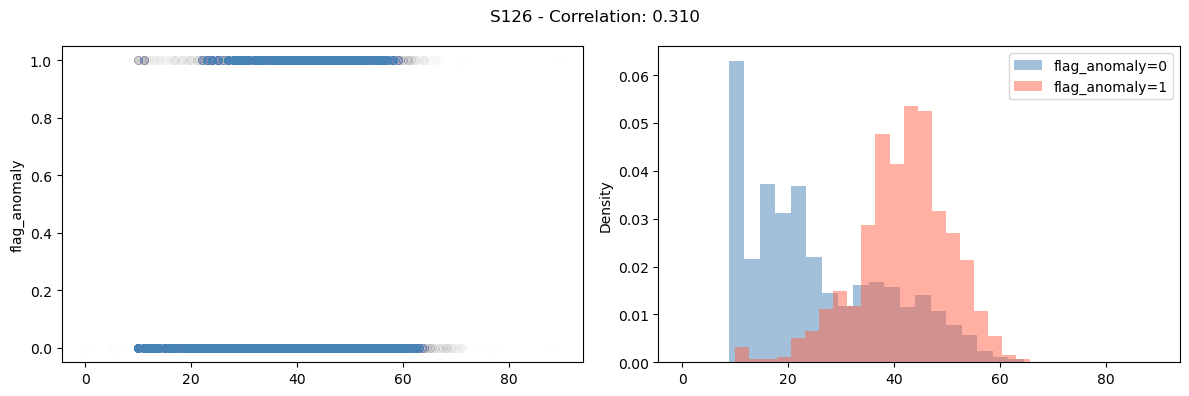

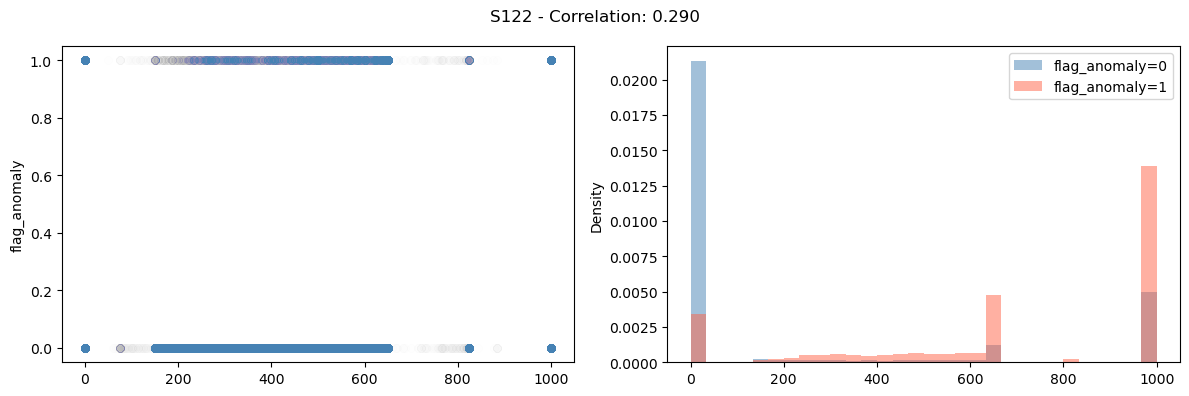

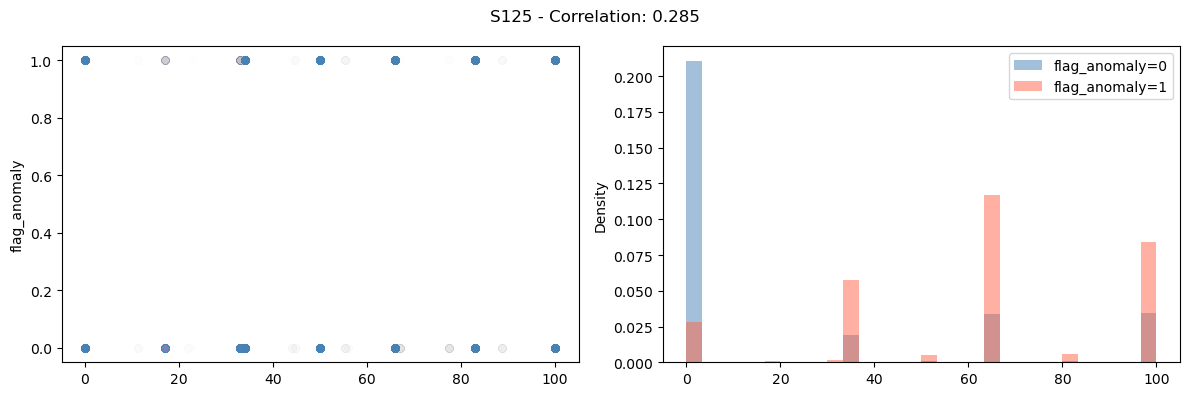

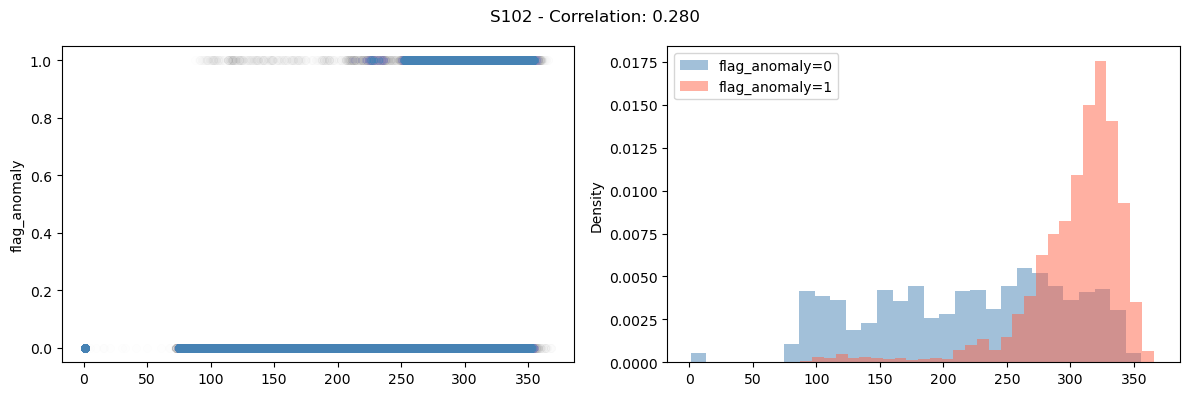

In [63]:
plot_correlations( df_final, "flag_anomaly", top_anomaly_corr, anomaly_corr )

# Device load vs Eternal temperature (S125-S181 vs S41)

# Correlations A5 e A9 alarms

In [45]:
%%time

alarm_corr = correlations(df_final.select(*useful_sensors,"overheating"), useful_sensors, "overheating")
top_alarm_corr = alarm_corr.head(5)["Sensors"].tolist()

CPU times: user 24.9 ms, sys: 4.72 ms, total: 29.6 ms
Wall time: 7.06 s


In [46]:
alarm_corr.head(5)

,Sensors,Correlations
0,S10,0.0
1,S100,0.0
2,S102,0.0
3,S109,0.0
4,S112,0.0


plot_correlations( df_final, "overheating", top_alarm_corr, alarm_corr )

# Predictive Maintenance

## Random Forest (su flag_anomaly)

In [38]:
#Model the training set balancing the flag anomalies ratio
df_final_flag0 = df_final.filter(col('flag_anomaly')==0)
df_final_flag1 = df_final.filter(col('flag_anomaly')==1)

to_drop_df = df_final_flag0.sample(withReplacement = False, fraction = 0.73, seed = 2503)

df_final_flag0_reduced = df_final_flag0.subtract(to_drop_df)

df_final_balanced = df_final_flag1.union(df_final_flag0_reduced)


#Check for the ratio between the flag anomalies 1 and 0
flag_ratio = df_final_balanced.filter(col('flag_anomaly')==1).count()/df_final_balanced.filter(col('flag_anomaly')==0).count()

print("Ratio [1/0]:",flag_ratio)

[Stage 1183:==========================================>             (3 + 1) / 4]

Ratio [1/0]: 1.0604298004249242


In [39]:
vector_to_drop = ['A5', 'A9', 'ComError', 'overheating']

sensors_forest = [s for s in sensors if s not in vector_to_drop]

df_final_balanced = df_final_balanced.drop(*vector_to_drop).na.drop()

In [40]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

def run_random_forest(df, feature_cols, label_col="label", n_trees=100, max_depth=5, test_fraction=0.2, seed = 2503):
    
    train_df, test_df = df.randomSplit([1 - test_fraction, test_fraction], seed=seed)
    print(f"Training on {train_df.count()} rows, testing on {test_df.count()} rows")
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    rf = RandomForestClassifier(labelCol=label_col, featuresCol="features", numTrees=n_trees, maxDepth=max_depth,  seed=seed)

    pipeline = Pipeline(stages=[assembler, rf]) #La pipeline serve per dire a Spark di eseguire due operazioni consecutive, poi Spark si arrangia a gestirle in questo modo

    model = pipeline.fit(train_df) 

    train_predictions = model.transform(train_df)
    test_predictions = model.transform(test_df)

    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    test_accuracy = evaluator.evaluate(test_predictions)

    print(f"RandomForest trained with {n_trees} trees, maxDepth={max_depth}")
    print(f"Test Accuracy = {test_accuracy:.4f}")

    rf_model = model.stages[-1] 
    importances = rf_model.featureImportances.toArray()
    feature_importance = sorted(zip(feature_cols, importances), key=lambda x: -x[1])

    print("\nFeature Importances:")
    for col, imp in feature_importance:
        print(f"{col}: {imp:.4f}")

    return model, train_predictions, test_predictions, test_accuracy

In [43]:
%%time

model, train_preds, test_preds, test_accuracy = run_random_forest(df_final_balanced, feature_cols=sensors_forest, label_col="flag_anomaly", n_trees = 120, max_depth = 10, test_fraction=0.33333)

test_preds.select('flag_anomaly', 'prediction', 'probability').show(10, truncate = 0)

Training on 37917 rows, testing on 18912 rows


25/08/20 15:24:38 WARN DAGScheduler: Broadcasting large task binary with size 1030.9 KiB
25/08/20 15:24:38 WARN DAGScheduler: Broadcasting large task binary with size 1154.2 KiB
25/08/20 15:24:39 WARN DAGScheduler: Broadcasting large task binary with size 1369.6 KiB
25/08/20 15:24:40 WARN DAGScheduler: Broadcasting large task binary with size 1720.1 KiB
25/08/20 15:24:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/08/20 15:24:42 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/08/20 15:24:44 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/08/20 15:24:46 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
25/08/20 15:25:34 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
                                                                                

RandomForest trained with 120 trees, maxDepth=10
Test Accuracy = 0.8838

Feature Importances:
S109: 0.1130
S166: 0.0902
S102: 0.0896
S126: 0.0765
S10: 0.0707
S159: 0.0630
S39: 0.0625
S112: 0.0462
S41: 0.0442
S5: 0.0407
S171: 0.0300
S125: 0.0256
S151: 0.0252
S81: 0.0251
S94: 0.0229
S100: 0.0201
S178: 0.0201
S122: 0.0163
S130: 0.0152
S71: 0.0141
S157: 0.0134
S40: 0.0128
S73: 0.0124
S138: 0.0111
S181: 0.0101
S128: 0.0086
S169: 0.0056
S201: 0.0042
S117: 0.0042
S170: 0.0026
S118: 0.0019
S204: 0.0019
P1: 0.0000
P10: 0.0000
P15: 0.0000
P16: 0.0000
P17: 0.0000
P18: 0.0000
P2: 0.0000
P5: 0.0000
P6: 0.0000
P7: 0.0000
P8: 0.0000
P9: 0.0000
S1: 0.0000
S101: 0.0000
S106: 0.0000
S107: 0.0000
S108: 0.0000
S11: 0.0000
S110: 0.0000
S113: 0.0000
S114: 0.0000
S115: 0.0000
S123: 0.0000
S124: 0.0000
S127: 0.0000
S129: 0.0000
S137: 0.0000
S140: 0.0000
S143: 0.0000
S147: 0.0000
S15: 0.0000
S154: 0.0000
S158: 0.0000
S16: 0.0000
S163: 0.0000
S164: 0.0000
S165: 0.0000
S167: 0.0000
S17: 0.0000
S172: 0.0000
S173:

25/08/20 15:25:52 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


+------------+----------+----------------------------------------+
|flag_anomaly|prediction|probability                             |
+------------+----------+----------------------------------------+
|1           |1.0       |[0.09083891888448091,0.9091610811155191]|
|1           |1.0       |[0.27860594763480706,0.7213940523651928]|
|1           |1.0       |[0.45715723352044474,0.5428427664795552]|
|1           |1.0       |[0.2982885199382337,0.7017114800617664] |
|1           |1.0       |[0.30749292968836467,0.6925070703116353]|
|1           |1.0       |[0.16960591763214916,0.8303940823678508]|
|1           |1.0       |[0.17067174633594745,0.8293282536640525]|
|1           |1.0       |[0.13140948700199984,0.8685905129980002]|
|1           |1.0       |[0.3819225550921914,0.6180774449078086] |
|1           |1.0       |[0.4279473675079294,0.5720526324920706] |
+------------+----------+----------------------------------------+
only showing top 10 rows

CPU times: user 182 ms, sys: 82.9 ms

In [65]:
#Prediction with the obtained model
n = 8
data_row = df_final_balanced.orderBy(rand()).limit(n)

predicted_data = model.transform(data_row)
predicted_data.select("S109", "S166", "S102", "flag_anomaly", "prediction").show()

[Stage 5524:============================================>           (4 + 1) / 5]

+-----+-----+-----+------------+----------+
| S109| S166| S102|flag_anomaly|prediction|
+-----+-----+-----+------------+----------+
|172.0|185.0| 99.0|           0|       0.0|
|533.0|613.0|204.0|           1|       1.0|
|325.0|508.0|116.0|           1|       1.0|
|497.0|477.0|181.5|           1|       1.0|
|565.0|524.0|206.0|           0|       0.0|
|105.0|118.0| 79.0|           0|       0.0|
|537.0|339.0|191.0|           1|       1.0|
|456.0|216.0|170.5|           1|       1.0|
+-----+-----+-----+------------+----------+



25/08/20 15:43:03 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
                                                                                

## Before Oveheating (predictive flag)

In [85]:
print("prima mi preparo una colonna flag che mi dice quali dati sono stati presi al max 30 min prima dell'overheating")

prima mi preparo una colonna flag che mi dice quali dati sono stati presi al max 30 min prima dell'overheating


In [86]:
list_hw

['SW-088', 'SW-106', 'SW-115', 'SW-065']

In [88]:
df_final088 = list_df_final['SW-088']

In [156]:
def add_predictive(df, window_before_heating=30, debug=False): #window_before_heating in minutes

    w = Window.partitionBy("BlockID").orderBy("when")

    # 1. individua inizio sequenza
    df = df.withColumn("prev_overheating", lag("overheating").over(w))
    df = df.withColumn(
        "is_start",
        when(
            (col("overheating") == 1) &
            ((col("prev_overheating") != 1) | col("prev_overheating").isNull()),
            1
        ).otherwise(0)
    )

    # 2. timestamp inizio sequenza (solo sugli start)
    df = df.withColumn("start_time", when(col("is_start") == 1, col("when")))

    # 3. propaga verso il futuro: "il prossimo start_time"
    w_future = w.rowsBetween(Window.currentRow, Window.unboundedFollowing)
    df = df.withColumn(
        "next_start_time",
        first("start_time", ignorenulls=True).over(w_future)
    )

    # 4. calcola predictive: nei 30 minuti prima del prossimo inizio sequenza
    window_seconds = window_before_heating * 60
    df = df.withColumn(
        "predictive",
        when(
            (col("next_start_time").isNotNull()) &
            (col("overheating") == 0) &
            ((col("next_start_time") - col("when")) > 0) &
            ((col("next_start_time") - col("when")) <= window_seconds),
            1
        ).otherwise(0)
    )

    if debug:
        return df.select("BlockID","when","window_start","overheating","prev_overheating",
                         "is_start","start_time","next_start_time","predictive")
    else:
        return df.select("BlockID","when","overheating","predictive")

In [157]:
df_predictive = add_predictive(df_final088.select("when","window_start","BlockID","overheating"), window_before_heating=30, debug = True )

In [158]:
df_predictive.where( col("overheating") == 1 ).orderBy(col("when").asc()).show(50)

[Stage 2725:============================>                           (1 + 1) / 2]

+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|BlockID|      when|       window_start|overheating|prev_overheating|is_start|start_time|next_start_time|predictive|
+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|      0|1601510790|2020-10-01 00:06:00|          1|               0|       1|1601510790|     1601510790|         0|
|      5|1601597190|2020-10-02 00:06:00|          1|               0|       1|1601597190|     1601597190|         0|
|      8|1601686290|2020-10-03 00:51:00|          1|               0|       1|1601686290|     1601686290|         0|
|     13|1601769750|2020-10-04 00:02:00|          1|               0|       1|1601769750|     1601769750|         0|
|     20|1601856330|2020-10-05 00:05:00|          1|               0|       1|1601856330|     1601856330|         0|
|     26|1601942610|2020-10-06 00:03:00|          1|            

In [159]:
df_predictive.where( col("BlockID") == 723 ).orderBy( col("when").desc() ).show(5)

+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|BlockID|      when|       window_start|overheating|prev_overheating|is_start|start_time|next_start_time|predictive|
+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|    723|1612537230|2021-02-05 15:00:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612537170|2021-02-05 14:59:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612537050|2021-02-05 14:57:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612536990|2021-02-05 14:56:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612536930|2021-02-05 14:55:00|          0|               0|       0|      NULL|           NULL|         0|
+-------+----------+-------------------+-----------+------------

In [160]:
df_predictive.where( (col("when") >= 1612537050) & (col("when") <= 1612540710) ).orderBy(col("when").asc()).show(50)

[Stage 2807:============================>                           (1 + 1) / 2]

+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|BlockID|      when|       window_start|overheating|prev_overheating|is_start|start_time|next_start_time|predictive|
+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|    723|1612537050|2021-02-05 14:57:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612537170|2021-02-05 14:59:00|          0|               0|       0|      NULL|           NULL|         0|
|    723|1612537230|2021-02-05 15:00:00|          0|               0|       0|      NULL|           NULL|         0|
|    724|1612539450|2021-02-05 15:37:00|          0|            NULL|       0|      NULL|     1612540530|         1|
|    724|1612539510|2021-02-05 15:38:00|          0|               0|       0|      NULL|     1612540530|         1|
|    724|1612539570|2021-02-05 15:39:00|          0|            

In [161]:
df_predictive.where( (col("when") >= 1612049850) & (col("when") <= 1612051890) ).orderBy(col("when").asc()).show(60)

[Stage 2848:============================>                           (1 + 1) / 2]

+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|BlockID|      when|       window_start|overheating|prev_overheating|is_start|start_time|next_start_time|predictive|
+-------+----------+-------------------+-----------+----------------+--------+----------+---------------+----------+
|    681|1612049850|2021-01-30 23:37:00|          0|               0|       0|      NULL|     1612051830|         0|
|    681|1612049910|2021-01-30 23:38:00|          0|               0|       0|      NULL|     1612051830|         0|
|    681|1612049970|2021-01-30 23:39:00|          0|               0|       0|      NULL|     1612051830|         0|
|    681|1612050030|2021-01-30 23:40:00|          0|               0|       0|      NULL|     1612051830|         1|
|    681|1612050090|2021-01-30 23:41:00|          0|               0|       0|      NULL|     1612051830|         1|
|    681|1612050150|2021-01-30 23:42:00|          0|            

In [162]:
# join predictive column

df_final088 = df_final088.join( df_predictive.select('when', 'predictive') , on='when', how='left' )
df_final088.printSchema()

root
 |-- when: long (nullable = true)
 |-- hwid: string (nullable = true)
 |-- window_start: timestamp_ntz (nullable = true)
 |-- window_end: timestamp_ntz (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: double (nullable = true)
 |-- P1: double (nullable = true)
 |-- P10: double (nullable = true)
 |-- P15: double (nullable = true)
 |-- P16: double (nullable = true)
 |-- P17: double (nullable = true)
 |-- P18: double (nullable = true)
 |-- P2: double (nullable = true)
 |-- P5: double (nullable = true)
 |-- P6: double (nullable = true)
 |-- P7: double (nullable = true)
 |-- P8: double (nullable = true)
 |-- P9: double (nullable = true)
 |-- S1: double (nullable = true)
 |-- S10: double (nullable = true)
 |-- S100: double (nullable = true)
 |-- S101: double (nullable = true)
 |-- S102: double (nullable = true)
 |-- S106: double (nullable = true)
 |-- S107: double (nullable = true)
 |-- S108: double (nullable = true)
 |-- S109: double

## SVM / RegressioneLogistica (su alarm)

In [163]:
top_corr_alarm = ["S53","S7","S172","S173","S39","S40"]

In [166]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import numpy as np

# 1. Remove rows with NULL values in target columns
df_clean = df_final088.na.drop(subset=top_corr_alarm)
print(f"Original rows: {df_final088.count()}, Clean rows: {df_clean.count()}")

# 2. Assemble features into vector
assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="features")
df_features = assembler.transform(df_clean)

# 3. Split data
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

# 4. Create and train logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="predictive")
lr_model = lr.fit(train_data)

# 5. Display model coefficients
print("=== MODEL COEFFICIENTS ===")
print(f"Intercept: {lr_model.intercept:.4f}")
for feature, coeff in zip(top_corr_alarm, lr_model.coefficients):
    direction = "increases" if coeff > 0 else "decreases"
    print(f"{feature}: {coeff:.4f} - {direction} P(predictive=1)")

# 6. Make predictions
predictions = lr_model.transform(test_data)

# 7. Extract probability of predictive=1
get_prob_1 = udf(lambda prob: float(prob[1]), DoubleType())
predictions_with_prob = predictions.withColumn("prob_predictive_1", get_prob_1(col("probability")))

print("\n=== SAMPLE PREDICTIONS ===")
predictions_with_prob.select("predictive", "prob_predictive_1").show(10)

# 8. Model evaluation
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="predictive")
auc = evaluator.evaluate(predictions)
summary = lr_model.summary

print(f"\n=== MODEL PERFORMANCE ===")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {summary.accuracy:.4f}")

# 9. Manual probability calculation function
def calculate_probability(feature_values):
    """Calculate P(predictive=1) = 1 / (1 + exp(-(intercept + sum(coeff_i * x_i))))"""
    linear_combination = lr_model.intercept + sum(coeff * val for coeff, val in zip(lr_model.coefficients, feature_values))
    return 1 / (1 + np.exp(-linear_combination))

# Example usage
example_values = [0.0, 1.0, 0.5, 0.2, 1.1, 0.8]  # Replace with actual sensor values
manual_prob = calculate_probability(example_values)
print(f"\nManual calculation example: {manual_prob:.4f}")

Original rows: 191987, Clean rows: 185879


25/08/19 21:30:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

=== MODEL COEFFICIENTS ===
Intercept: -15.3732
S53: -2.4931 - decreases P(predictive=1)
S7: 8.9245 - increases P(predictive=1)
S172: 4.9154 - increases P(predictive=1)
S173: 3.3085 - increases P(predictive=1)
S39: 0.0057 - increases P(predictive=1)
S40: -0.0059 - decreases P(predictive=1)

=== SAMPLE PREDICTIONS ===


+----------+--------------------+
|predictive|   prob_predictive_1|
+----------+--------------------+
|         0|0.017112218708874583|
|         0|0.017008628111901403|
|         0| 0.01710435224478024|
|         0|0.017124025070843762|
|         0|0.017020364240471597|
|         0|0.017012539270886196|
|         0|0.017131900424966817|
|         0| 0.01703602479149824|
|         0|0.017124025070843762|
|         0| 0.01702819274682843|
+----------+--------------------+
only showing top 10 rows




=== MODEL PERFORMANCE ===
AUC: 0.7859


[Stage 3894:============================================>           (4 + 1) / 5]

Accuracy: 0.9928

Manual calculation example: 0.0346


Original rows: 191987, Clean rows: 185879


=== SVM HYPERPLANE ===
Intercept: -2.1363
Coefficients (hyperplane): [0.5016083527204447,0.5187872820349008,0.11583300041665565,-0.11229206641327225,-0.000427472703329341,0.0004234862393562192]

=== COEFFICIENT INTERPRETATION ===
S53: 0.5016 - pushes towards predictive=1
S7: 0.5188 - pushes towards predictive=1
S172: 0.1158 - pushes towards predictive=1
S173: -0.1123 - pushes towards predictive=0
S39: -0.0004 - pushes towards predictive=0
S40: 0.0004 - pushes towards predictive=1

=== SAMPLE PREDICTIONS ===


+----------+----------+
|predictive|prediction|
+----------+----------+
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
+----------+----------+
only showing top 10 rows




=== MODEL PERFORMANCE ===
AUC: 0.7597
Accuracy: 0.9932
Correct predictions: 36877/37128

=== COMBINATION COLUMN ADDED ===


+----------+-------------------+---+---+----+----+-----+-----+
|predictive|        combination|S53| S7|S172|S173|  S39|  S40|
+----------+-------------------+---+---+----+----+-----+-----+
|         0| -1.000433386891539|1.0|1.0| 1.0| 0.0|103.0|103.0|
|         1| -1.000433386891539|1.0|1.0| 1.0| 0.0|103.0|103.0|
|         1|-1.0000059141882096|1.0|1.0| 1.0| 0.0|102.0|103.0|
|         1| -1.000856873130895|1.0|1.0| 1.0| 0.0|103.0|102.0|
|         0| -1.000433386891539|1.0|1.0| 1.0| 0.0|103.0|103.0|
+----------+-------------------+---+---+----+----+-----+-----+
only showing top 5 rows




=== PLOTTING DATA ===
Data shape: (185879, 8)
Combination stats:
  Min: -2.2696
  Max: -0.9901
  Mean: -1.6098


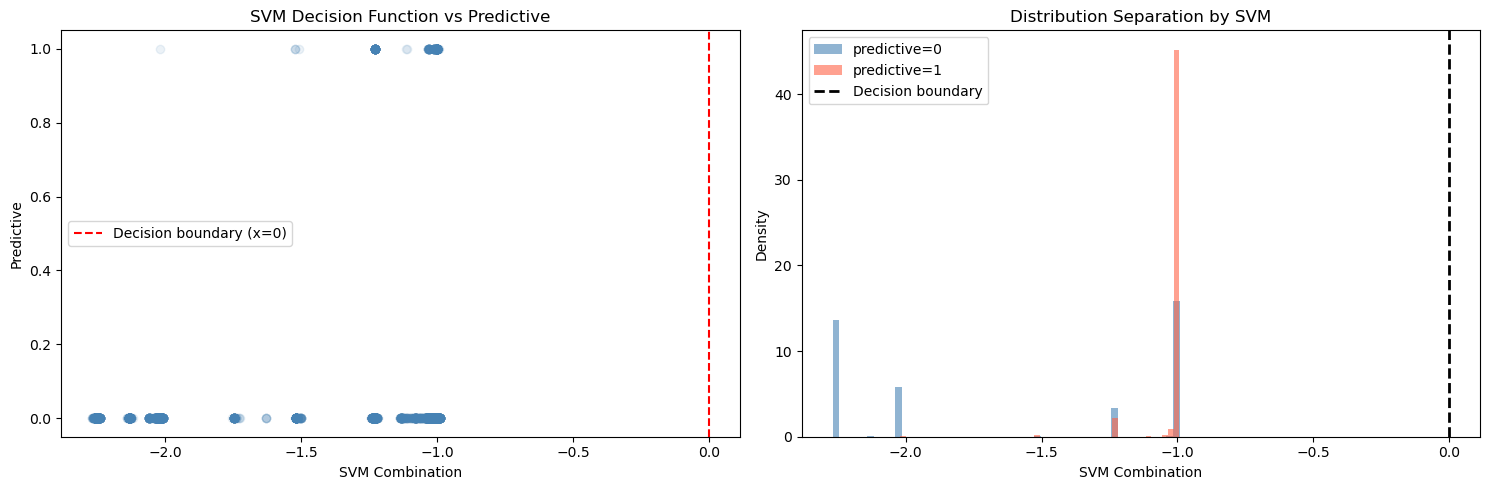


=== SEPARATION QUALITY ===
Class 0 (predictive=0): mean=-1.6140, std=0.5771
Class 1 (predictive=1): mean=-1.0146, std=0.0614
Mean difference: 0.5994
Decision boundary accuracy: 0.9929 (184557/185879)


In [168]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# 1. Remove rows with NULL values in target columns
df_clean = df_final088.na.drop(subset=top_corr_alarm)
print(f"Original rows: {df_final088.count()}, Clean rows: {df_clean.count()}")

# 2. Assemble features into vector
assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="features")
df_features = assembler.transform(df_clean)

# 3. Split data
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

# 4. Create and train SVM model
svc = LinearSVC(featuresCol="features", labelCol="predictive")
svc_model = svc.fit(train_data)

# 5. Display model coefficients (hyperplane)
print("=== SVM HYPERPLANE ===")
print(f"Intercept: {svc_model.intercept:.4f}")
print("Coefficients (hyperplane):", svc_model.coefficients)

print("\n=== COEFFICIENT INTERPRETATION ===")
for feature, coeff in zip(top_corr_alarm, svc_model.coefficients):
    direction = "pushes towards predictive=1" if coeff > 0 else "pushes towards predictive=0"
    print(f"{feature}: {coeff:.4f} - {direction}")

# 6. Make predictions
predictions = svc_model.transform(test_data)

print("\n=== SAMPLE PREDICTIONS ===")
predictions.select("predictive", "prediction").show(10)

# 7. Model evaluation
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="predictive")
auc = evaluator.evaluate(predictions)

# Count correct predictions
total_predictions = predictions.count()
correct_predictions = predictions.filter(col("predictive") == col("prediction")).count()
accuracy = correct_predictions / total_predictions

print(f"\n=== MODEL PERFORMANCE ===")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Correct predictions: {correct_predictions}/{total_predictions}")

# 8. Add combination column using SVM coefficients
from pyspark.sql.functions import lit

# Calculate linear combination: intercept + sum(coeff_i * x_i)
combination_expr = lit(svc_model.intercept)
for i, (feature, coeff) in enumerate(zip(top_corr_alarm, svc_model.coefficients)):
    combination_expr = combination_expr + (col(feature) * lit(float(coeff)))

df_with_combination = df_clean.withColumn("combination", combination_expr)

print(f"\n=== COMBINATION COLUMN ADDED ===")
df_with_combination.select("predictive", "combination", *top_corr_alarm).show(5)

# 9. Convert to Pandas for plotting
import matplotlib.pyplot as plt

pd_df = df_with_combination.select("predictive", "combination", *top_corr_alarm).toPandas()

print(f"\n=== PLOTTING DATA ===")
print(f"Data shape: {pd_df.shape}")
print(f"Combination stats:")
print(f"  Min: {pd_df['combination'].min():.4f}")
print(f"  Max: {pd_df['combination'].max():.4f}")
print(f"  Mean: {pd_df['combination'].mean():.4f}")

# 10. Create plots
# Plot 1: Scatter plot of combination vs predictive
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
ax1.scatter(pd_df['combination'], pd_df['predictive'], color="steelblue", alpha=0.1)
ax1.axvline(x=0, color='red', linestyle='--', label='Decision boundary (x=0)')
ax1.set_xlabel('SVM Combination')
ax1.set_ylabel('Predictive')
ax1.set_title('SVM Decision Function vs Predictive')
ax1.legend()

# Histogram showing separated distributions
for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
    subset = pd_df[pd_df['predictive'] == target_val]
    ax2.hist(subset['combination'], bins=50, alpha=0.6, color=color, 
             label=f"predictive={target_val}", density=True)

ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision boundary')
ax2.set_xlabel('SVM Combination')
ax2.set_ylabel('Density')
ax2.set_title('Distribution Separation by SVM')
ax2.legend()

plt.tight_layout()
plt.show()

# 11. Print separation quality
negative_class = pd_df[pd_df['predictive'] == 0]['combination']
positive_class = pd_df[pd_df['predictive'] == 1]['combination']

print(f"\n=== SEPARATION QUALITY ===")
print(f"Class 0 (predictive=0): mean={negative_class.mean():.4f}, std={negative_class.std():.4f}")
print(f"Class 1 (predictive=1): mean={positive_class.mean():.4f}, std={positive_class.std():.4f}")
print(f"Mean difference: {positive_class.mean() - negative_class.mean():.4f}")

# Percentage of correct classifications using decision boundary at 0
correct_predictions = ((pd_df['combination'] > 0) == (pd_df['predictive'] == 1)).sum()
total_predictions = len(pd_df)
boundary_accuracy = correct_predictions / total_predictions
print(f"Decision boundary accuracy: {boundary_accuracy:.4f} ({correct_predictions}/{total_predictions})")

# <hr style="height:4px; background-color:black; border:none;" />